In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/neuron-data/DATA_CN_Project_III_A17.mat


## **1) Stimulus nature**

In [2]:
import scipy
# Load the newly uploaded MAT file
mat_file_path = "/kaggle/input/neuron-data/DATA_CN_Project_III_A17.mat"
data = scipy.io.loadmat(mat_file_path)

# Check the available variables in the file
data.keys()


dict_keys(['__header__', '__version__', '__globals__', 'All_Spike_Times', 'Stimulus'])

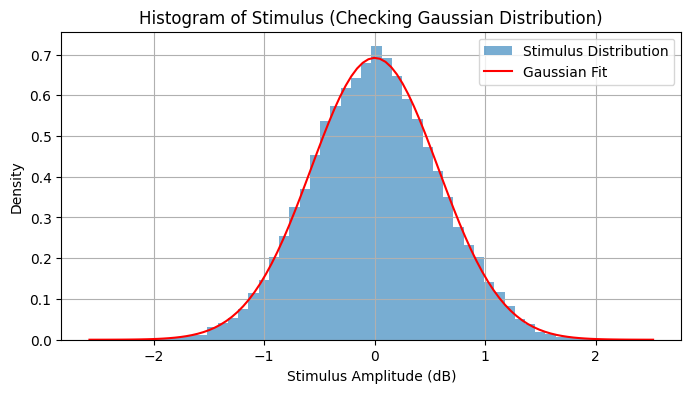

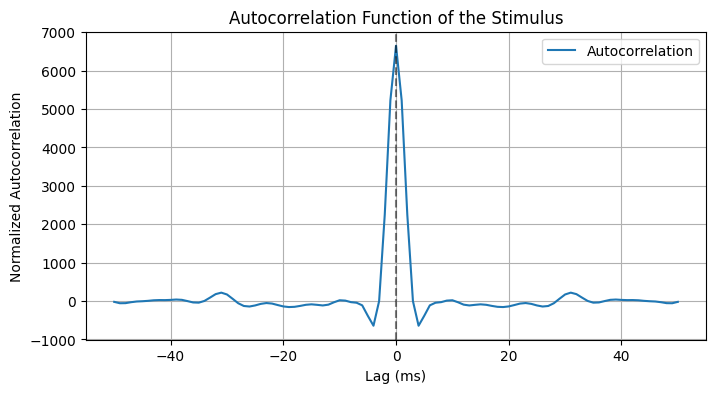

0.6539269409419118

In [3]:
import matplotlib.pyplot as plt
# Extract the stimulus data
stimulus = data['Stimulus'].flatten()  # Convert to 1D array if necessary

# Check basic statistics
mean_stim = np.mean(stimulus)
std_stim = np.std(stimulus)

# Perform normality test (Kolmogorov-Smirnov test)
ks_stat, ks_p_value = scipy.stats.kstest(stimulus, 'norm', args=(mean_stim, std_stim))

# Plot histogram to visualize the distribution
plt.figure(figsize=(8, 4))
plt.hist(stimulus, bins=50, density=True, alpha=0.6, label="Stimulus Distribution")
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
plt.plot(x, scipy.stats.norm.pdf(x, mean_stim, std_stim), 'r', label="Gaussian Fit")
plt.xlabel("Stimulus Amplitude (dB)")
plt.ylabel("Density")
plt.title("Histogram of Stimulus (Checking Gaussian Distribution)")
plt.legend()
plt.grid()
plt.show()

# Compute and plot the autocorrelation function
tau_range = np.arange(-50, 51, 1)  # Lag range in ms
autocorr = np.correlate(stimulus, stimulus, mode='full')
autocorr = autocorr[len(autocorr)//2 - 50 : len(autocorr)//2 + 51]  # Extract relevant range



# Plot the autocorrelation function
plt.figure(figsize=(8, 4))
plt.plot(tau_range, autocorr, label="Autocorrelation")
plt.xlabel("Lag (ms)")
plt.ylabel("Normalized Autocorrelation")
plt.title("Autocorrelation Function of the Stimulus")
plt.axvline(0, color='k', linestyle='--', alpha=0.5)  # Mark tau = 0
plt.legend()
plt.grid()
plt.show()

# Display normality test results
ks_p_value


In [4]:
data['All_Spike_Times'][0,0].shape

(1, 344)

## **2) PSTH and mean firing rate**

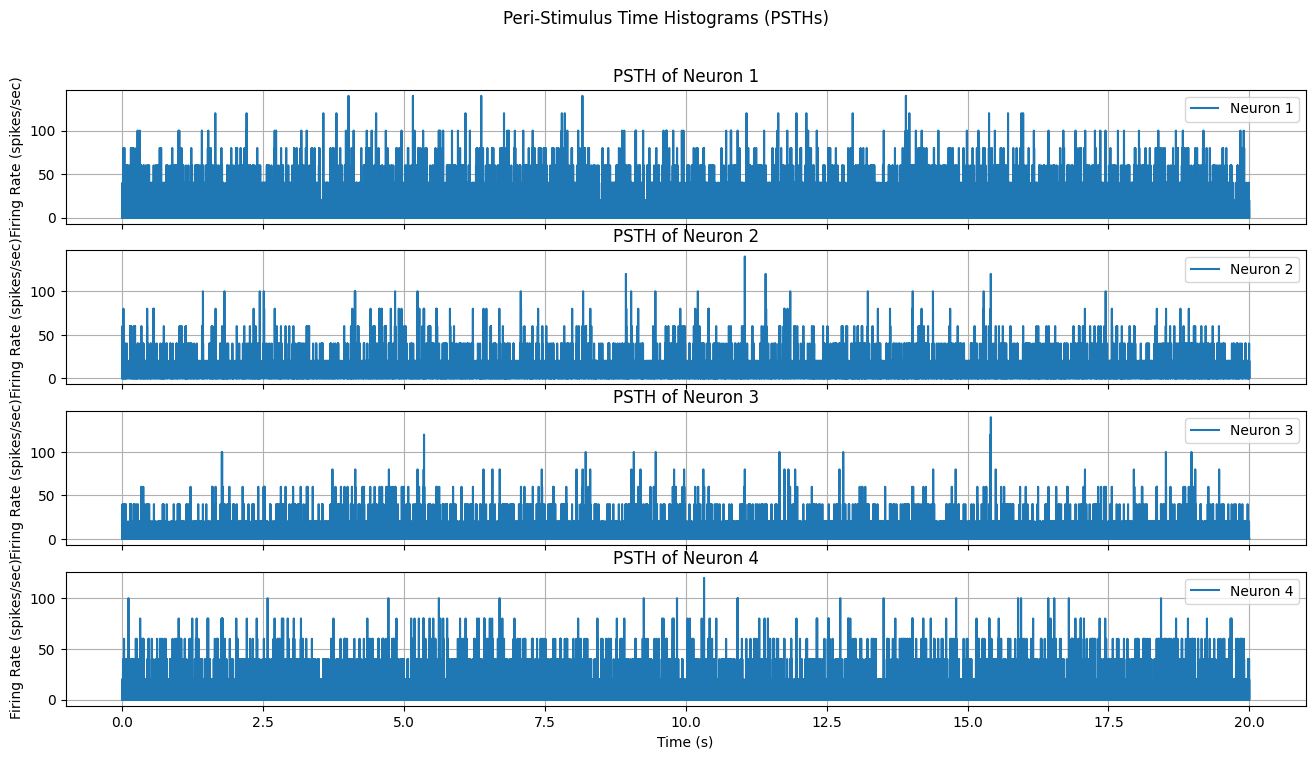

In [5]:
# Extract spike times data
all_spike_times = data['All_Spike_Times']  # This is a cell array (list of lists)

# Define parameters
num_neurons = 4
num_repetitions = 50
stimulus_duration = 20  # seconds
bin_size = 0.001  # 1 ms bins
num_bins = int(stimulus_duration / bin_size)

# Initialize PSTH matrix (rows: neurons, columns: time bins)
psth = np.zeros((num_neurons, num_bins))

# Compute PSTH for each neuron
time_bins = np.arange(0, stimulus_duration, bin_size)  # Time bins from 0 to 20s in 1ms steps

for i in range(num_neurons):
    spike_counts = np.zeros(num_bins)  # Initialize spike count array for PSTH
    for j in range(num_repetitions):
        spike_times = all_spike_times[i, j].flatten()  # Get spike times for neuron i in repetition j
        spike_indices = (spike_times / bin_size).astype(int)  # Convert spike times to bin indices
        spike_indices = spike_indices[spike_indices < num_bins]  # Ensure indices are within range
        np.add.at(spike_counts, spike_indices, 1)  # Increment spike count at the respective bins

    psth[i, :] = spike_counts / num_repetitions / bin_size  # Convert to spikes/sec

# Store last 5 seconds for prediction evaluation
prediction_psth = psth[:, -5000:]  # Last 5000 bins (5 seconds at 1ms resolution)

# Plot PSTHs for each neuron
fig, axes = plt.subplots(num_neurons, 1, figsize=(16, 8), sharex=True)

for i in range(num_neurons):
    axes[i].plot(time_bins, psth[i, :], label=f'Neuron {i+1}')
    axes[i].set_ylabel("Firing Rate (spikes/sec)")
    axes[i].set_title(f"PSTH of Neuron {i+1}")
    axes[i].legend()
    axes[i].grid()

axes[-1].set_xlabel("Time (s)")
plt.suptitle("Peri-Stimulus Time Histograms (PSTHs)")
plt.show()


## **3) Poisson or non-Poisson**

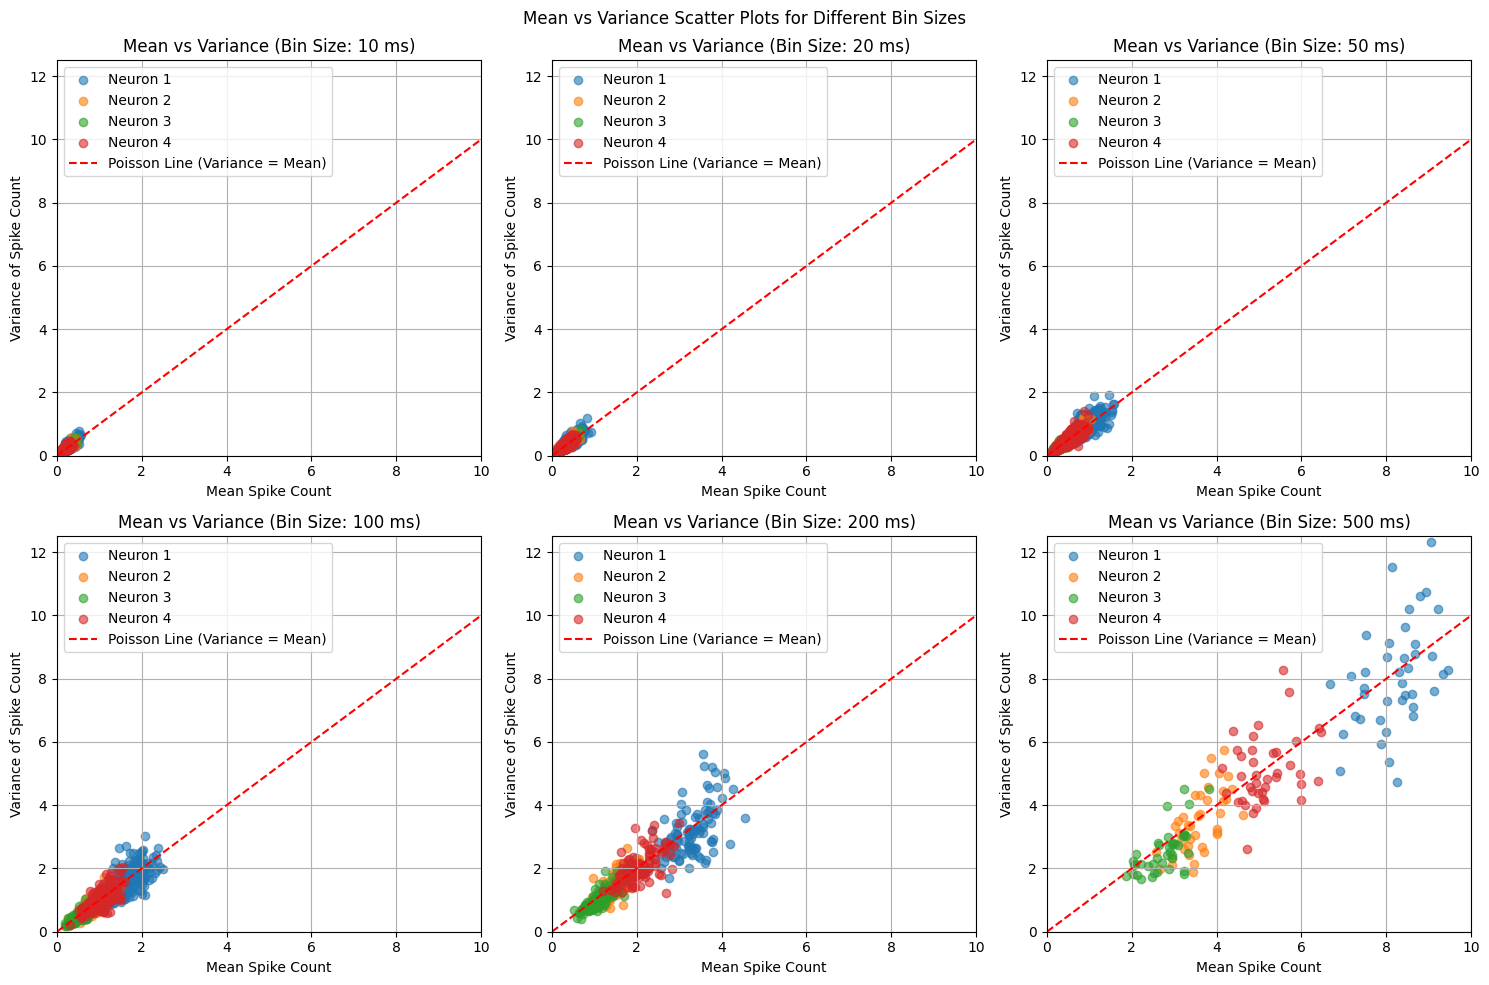

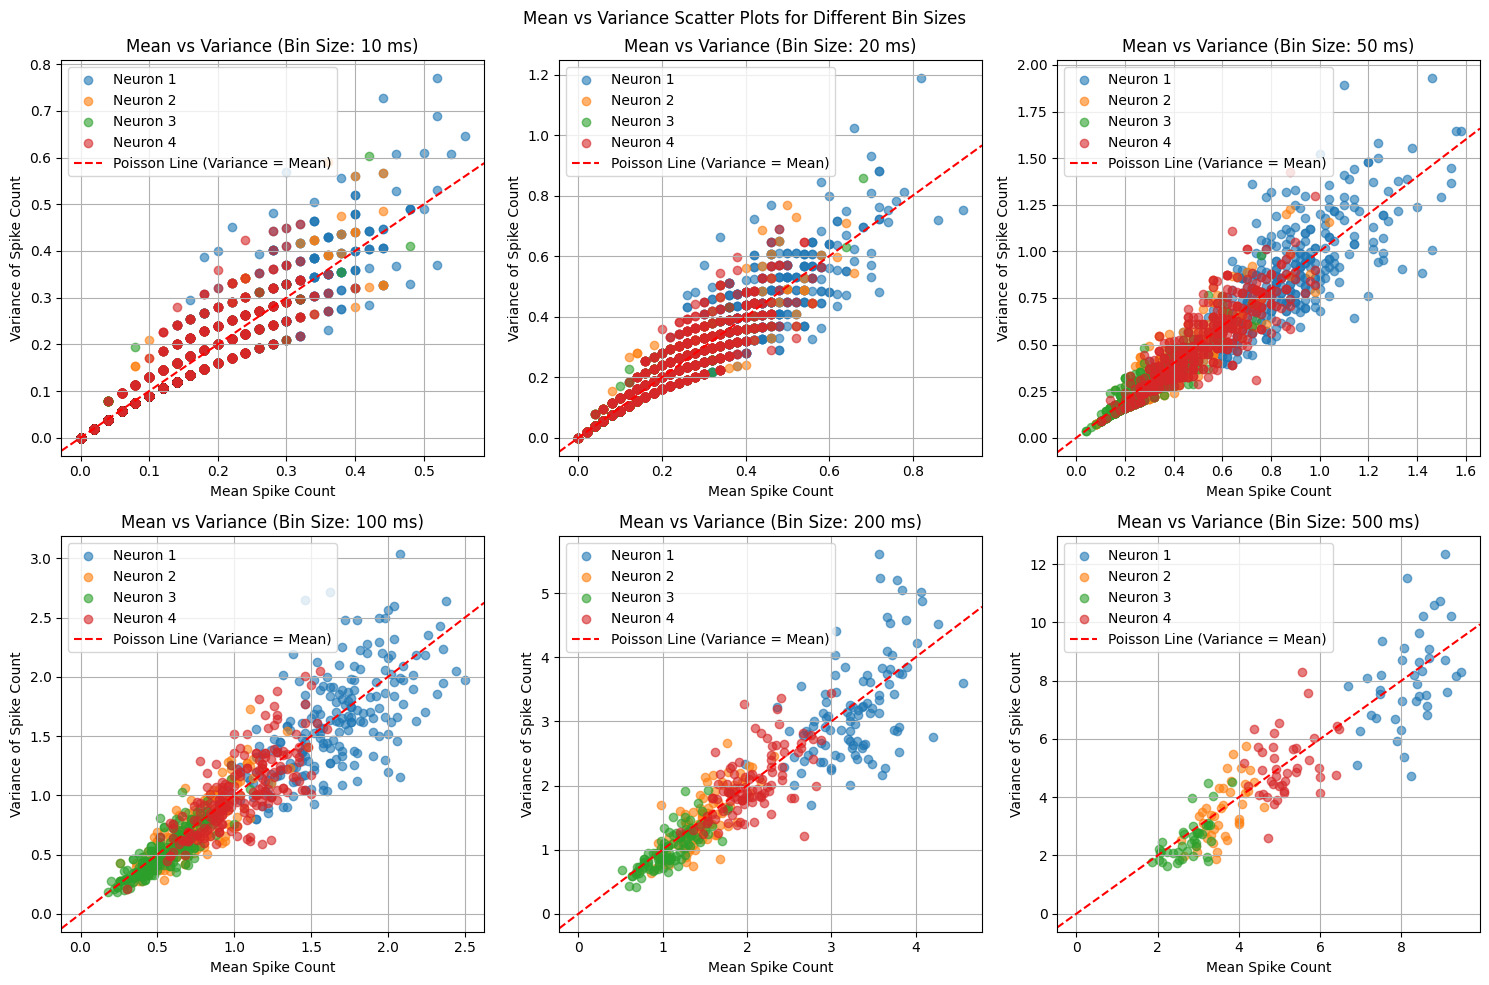

In [6]:
# Define different time bin sizes for analysis (in seconds)
bin_sizes = [0.010, 0.020, 0.050, 0.100, 0.200, 0.500]

# Dictionary to store mean and variance for each neuron at each bin size
mean_variance_data = {bin_size: {f"Neuron {i+1}": [] for i in range(num_neurons)} for bin_size in bin_sizes}

# Compute spike counts for each bin size
for bin_size in bin_sizes:
    num_bins = int(stimulus_duration / bin_size)  # Number of bins for the given bin size
    for i in range(num_neurons):
        spike_counts_per_bin = np.zeros((num_repetitions, num_bins))  # Shape: (50, num_bins)

        for j in range(num_repetitions):
            spike_times = all_spike_times[i, j].flatten()
            spike_indices = (spike_times / bin_size).astype(int)  # Convert spike times to bin indices
            spike_indices = spike_indices[spike_indices < num_bins]  # Ensure indices are within range
            np.add.at(spike_counts_per_bin[j, :], spike_indices, 1)  # Count spikes

        # Compute mean and variance for each bin across repetitions
        mean_spike_counts = np.mean(spike_counts_per_bin, axis=0)
        var_spike_counts = np.var(spike_counts_per_bin, axis=0)

        # Store results for plotting and analysis
        mean_variance_data[bin_size][f"Neuron {i+1}"] = (mean_spike_counts, var_spike_counts)

# Scatter plot: Mean vs Variance for different time bins
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns for 6 bin sizes
axes = axes.flatten()

for idx, bin_size in enumerate(bin_sizes):
    plt.subplot(2, 3, idx + 1)
    for i in range(num_neurons):
        mean_vals, var_vals = mean_variance_data[bin_size][f"Neuron {i+1}"]
        plt.scatter(mean_vals, var_vals, label=f"Neuron {i+1}", alpha=0.6)
    plt.xlim([0,10])
    plt.ylim([0,12.5])
    plt.xlabel("Mean Spike Count")
    plt.ylabel("Variance of Spike Count")
    plt.title(f"Mean vs Variance (Bin Size: {int(bin_size*1000)} ms)")
    plt.axline((0, 0), slope=1, color='red', linestyle="--", label="Poisson Line (Variance = Mean)")
    plt.legend()
    plt.grid()

plt.suptitle("Mean vs Variance Scatter Plots for Different Bin Sizes")
plt.tight_layout()
plt.show()

# Scatter plot: Mean vs Variance for different time bins
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns for 6 bin sizes
axes = axes.flatten()
for idx, bin_size in enumerate(bin_sizes):
    plt.subplot(2, 3, idx + 1)
    for i in range(num_neurons):
        mean_vals, var_vals = mean_variance_data[bin_size][f"Neuron {i+1}"]
        plt.scatter(mean_vals, var_vals, label=f"Neuron {i+1}", alpha=0.6)
    # plt.xlim([0,10])
    # plt.ylim([0,12.5])
    plt.xlabel("Mean Spike Count")
    plt.ylabel("Variance of Spike Count")
    plt.title(f"Mean vs Variance (Bin Size: {int(bin_size*1000)} ms)")
    plt.axline((0, 0), slope=1, color='red', linestyle="--", label="Poisson Line (Variance = Mean)")
    plt.legend()
    plt.grid()

plt.suptitle("Mean vs Variance Scatter Plots for Different Bin Sizes")
plt.tight_layout()
plt.show()



## 4) Spike triggered average (STA) [and correction for non-Gaussianity?] 


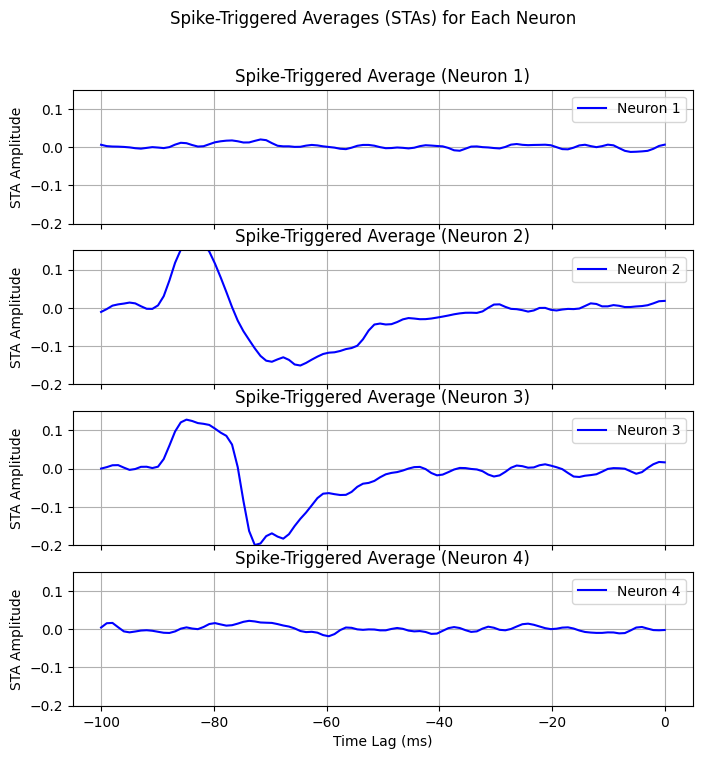

In [7]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import skew, kurtosis


# Extract relevant data
stimulus = data['Stimulus'].flatten()  # Convert to 1D array
all_spike_times = data['All_Spike_Times']
num_neurons = 4
num_repetitions = 50

# Define STA parameters
filter_length = 100  # in ms
filter_bins = int(filter_length * 1)  # 1 ms resolution
stimulus_sampling_rate = 1000  # 1 kHz sampling

# Only use the first 15 seconds of data
stimulus_train = stimulus[:15 * stimulus_sampling_rate]

# Initialize STA matrix (rows: neurons, columns: time bins)
sta_matrix = np.zeros((num_neurons, filter_bins)) #(4, 100)
 
# Compute Spike-Triggered Average (STA) for each neuron
for i in range(num_neurons):
    # Collect all spike times within the first 15 seconds for all repetitions
    all_spike_times_concat = np.concatenate([all_spike_times[i, j].flatten() for j in range(num_repetitions)])
    all_spike_times_concat = all_spike_times_concat[all_spike_times_concat < 15]  # Keep only first 15 seconds

    # Convert spike times to indices
    spike_indices = (all_spike_times_concat * stimulus_sampling_rate).astype(int)
    spike_indices = spike_indices[spike_indices >= filter_bins]  # Ignore spikes too early for filtering

    # Accumulate stimulus segments before each spike
    for spike_idx in spike_indices:
        sta_matrix[i, :] += stimulus_train[spike_idx - filter_bins: spike_idx]

    # Normalize by the number of spikes to get the average
    if len(spike_indices) > 0:
        sta_matrix[i, :] /= len(spike_indices)

# Plot STA for each neuron
time_lags = np.linspace(-filter_length, 0, filter_bins)  # Time lags from -100 ms to 0

fig, axes = plt.subplots(num_neurons, 1, figsize=(8, 8), sharex=True)

for i in range(num_neurons):
    axes[i].plot(time_lags, sta_matrix[i, :], label=f'Neuron {i+1}', color='b')
    axes[i].set_ylim(-0.2,0.15)
    axes[i].set_ylabel("STA Amplitude")
    axes[i].set_title(f"Spike-Triggered Average (Neuron {i+1})")
    axes[i].legend()
    axes[i].grid()

axes[-1].set_xlabel("Time Lag (ms)")
plt.suptitle("Spike-Triggered Averages (STAs) for Each Neuron")
plt.show()

# Check Gaussianity of stimulus and apply correction if necessary
stimulus_skew = skew(stimulus_train)
stimulus_kurtosis = kurtosis(stimulus_train)

correction_needed = abs(stimulus_skew) > 0.1 or abs(stimulus_kurtosis) > 0.1

#stimulus_skew, stimulus_kurtosis, correction_needed


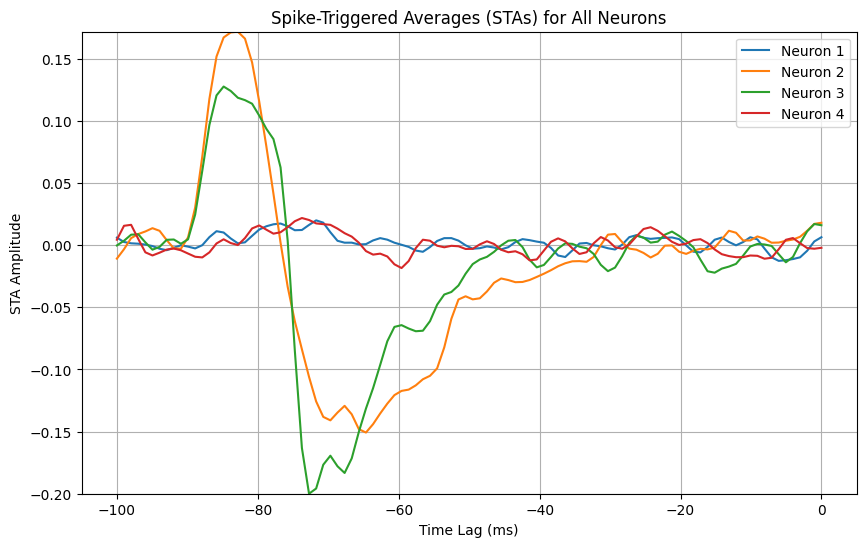

In [8]:
# Re-load the MAT file after execution state reset
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import skew, kurtosis


# Extract relevant data
stimulus = data['Stimulus'].flatten()  # Convert to 1D array
all_spike_times = data['All_Spike_Times']
num_neurons = 4
num_repetitions = 50

# Define STA parameters
filter_length = 100  # in ms
filter_bins = int(filter_length * 1)  # 1 ms resolution
stimulus_sampling_rate = 1000  # 1 kHz sampling

# Only use the first 15 seconds of data
stimulus_train = stimulus[:15 * stimulus_sampling_rate]

# Initialize STA matrix (rows: neurons, columns: time bins)
sta_matrix = np.zeros((num_neurons, filter_bins))

# Compute Spike-Triggered Average (STA) for each neuron
for i in range(num_neurons):
    # Collect all spike times within the first 15 seconds for all repetitions
    all_spike_times_concat = np.concatenate([all_spike_times[i, j].flatten() for j in range(num_repetitions)])
    all_spike_times_concat = all_spike_times_concat[all_spike_times_concat < 15]  # Keep only first 15 seconds

    # Convert spike times to indices
    spike_indices = (all_spike_times_concat * stimulus_sampling_rate).astype(int)
    spike_indices = spike_indices[spike_indices >= filter_bins]  # Ignore spikes too early for filtering

    # Accumulate stimulus segments before each spike
    for spike_idx in spike_indices:
        sta_matrix[i, :] += stimulus_train[spike_idx - filter_bins: spike_idx]

    # Normalize by the number of spikes to get the average
    if len(spike_indices) > 0:
        sta_matrix[i, :] /= len(spike_indices)

# Plot STA for all neurons on the same x-axis and y-limits
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(num_neurons):
    ax.plot(np.linspace(-filter_length, 0, filter_bins), sta_matrix[i, :], label=f'Neuron {i+1}')

ax.set_xlabel("Time Lag (ms)")
ax.set_ylabel("STA Amplitude")
ax.set_title("Spike-Triggered Averages (STAs) for All Neurons")
ax.legend()
ax.grid()

# Set consistent y-limits for comparison
y_min, y_max = np.min(sta_matrix), np.max(sta_matrix)
ax.set_ylim(y_min, y_max)

plt.show()

# Check Gaussianity of stimulus and apply correction if necessary
stimulus_skew = skew(stimulus_train)
stimulus_kurtosis = kurtosis(stimulus_train)
correction_needed = abs(stimulus_skew) > 0.1 or abs(stimulus_kurtosis) > 0.1

#stimulus_skew, stimulus_kurtosis, correction_needed
